# Lab 2 Decision Tree Program and Report

## decision tree code & missing value handling
I used part of the code from CS405-Machine Learning_DecisionTree_Lab.docx to write the decision tree. I used the method from *C4.5:by J. Ross Quinlan.* to handle missing attribute values.  If the spliting feature of a sample is unknown, the sample will enter all children node, with the weight multiply by a ratio of the child. Where the ratio is the number of samples(the spliting feature is known) belong the child to all samples used to split the parent node whose spliting feature is known.


In [209]:
import math


class Tree:
    def __init__(self, parent=None):
        self.parent = parent
        self.children = []
        self.featureSplit = None    # split according to featureSplit
        self.featureValue = None    # featureValue of parent.featureSplit of the node
        self.ratio = 1.0
        self.label = None


In [210]:
def DataToDistribution(data, weight):
    weight_total = sum(weight)
    labels = [label for (point, label) in data]
    distribution = []
    for aClass in set(labels):
        w_a_class = 0
        for (point, label), point_weight in zip(data, weight):
            if label == aClass:
                w_a_class += point_weight
        distribution.append(w_a_class / float(weight_total))
    return distribution


def ShannonEntropy(distribution):
    return -sum([p * math.log(p,2) for p in distribution])


def split_data(data, feature, weight):
    values = [point[feature] for (point, label) in data]
    for aValue in set(values):
        weight_data_set = []
        data_set = []
        for (point, label), point_weight in zip(data, weight):
            if point[feature] == aValue:
                data_set.append((point, label))
                weight_data_set.append(point_weight)
        yield data_set, weight_data_set
    
def majority(data, weight):
    labels = [label for (point, label) in data]
    major_class = None
    m = 0
    for aClass in set(labels):
        weight_aClass = 0
        for (point, label), point_weight in zip(data, weight):
            if label == aClass:
                weight_aClass += point_weight
        if weight_aClass > m:
            m = weight_aClass
            major_class = aClass
    return major_class


def info_gain(data, feature, weight):
    weight_total = sum(weight)
    data_weight = list(zip(data, weight))
    for (point, label), point_weight in zip(data, weight):
        if point[feature] == '?':
            data_weight.remove(((point, label), point_weight))
            
    data = []
    weight = []
    for (d, w) in data_weight:
        data.append(d)
        weight.append(w)
        
    weight_intact = sum(weight)
    ratio = weight_intact / float(weight_total)
    entropy = ShannonEntropy(DataToDistribution(data, weight))
    for dataSet, weight_dataSet in split_data(data, feature, weight):
        entropy -= sum(weight_dataSet) / float(sum(weight)) * ShannonEntropy(DataToDistribution(dataSet, weight_dataSet))
    info_gained = ratio * entropy
    return info_gained


In [211]:
def buildTree(data, parent, remaining_feature, weight):
    if [label for (point, label) in data].count(data[0][1]) == len(data):   # homogeneous
        parent.label = data[0][1]
        return parent
    if len(remaining_feature) == 0:     # can't split anymore
        parent.label = majority(data, weight)
        return parent
    best_feature = max(remaining_feature, key=lambda feature: info_gain(data, feature, weight)) 
    maxGained = info_gain(data, best_feature, weight)
    if maxGained == 0:
        parent.label = majority(data, weight)
        return parent
    
    parent.featureSplit = best_feature
    feature_values = [point[best_feature] for (point, label) in data]
    weight_intact_data = sum([point_weight for (point, label), point_weight in zip(data, weight) 
                              if point[best_feature] != '?'])
    
    for aFeatureValue in set(feature_values)-set('?'):
        node = Tree(parent=parent)
        node.featureValue = aFeatureValue
        data_set = []
        weight_dataSet = []
        for (point, label), point_weight in zip(data, weight):  # process (point,label) with feature aFeatureValue first
            if point[best_feature] == aFeatureValue:
                data_set.append((point, label))
                weight_dataSet.append(point_weight)
        r = sum(weight_dataSet) / weight_intact_data  # the weight ratio of intact_dataSet to intact_data
        node.ratio = r
        for (point, label), point_weight in zip(data, weight):
            if point[best_feature] == '?':
                data_set.append((point, label))
                weight_dataSet.append(r * point_weight)
        parent.children.append(node)
        buildTree(data_set, node, remaining_feature - set([best_feature]), weight_dataSet)
    return parent


def decision_tree(data):
    return buildTree(data, Tree(), set(range(len(data[0][0]))), [1] * len(data))
    

In [212]:
def classify(tree, point):
    result = []
    
    def classifying(tree, point, result, probability):
        if tree.children == []:
            result.append((tree.label, probability))
            return 
        elif point[tree.featureSplit] != '?':
            for child in tree.children:
                if point[tree.featureSplit] == child.featureValue:
                    classifying(child, point, result, probability)
                    return 
        else:
            for child in tree.children:     # point[tree.featureSplit == '?' enter node proportionally
                classifying(child, point, result, probability * child.ratio)
            # the total child ratio is a little bigger than 1.0 I'm puzzled about the result
    
    classifying(tree, point, result, 1.0)
    labels = [label for label, probability in result]
    result_merged = {}
    for label, probability in result:
        if label not in result_merged:
            result_merged[label] = probability
        else:
            result_merged[label] += probability
    label = max(set(labels), key=lambda label: result_merged[label])
    return label


In [213]:
def testClassification(tree, data):
    actualLabels = [label for (point, label) in data]
    predictedLabels = [classify(tree, point) for point, label in data]
    
    correctLabels = [(1 if a == b else 0) for a, b in zip(actualLabels, predictedLabels)]
    return float(sum(correctLabels)) / len(actualLabels)

In [214]:
with open("house-votes-1984.txt") as f:
    content = f.readlines()
content = [x.strip().split(',') for x in content] 

from sklearn.model_selection import train_test_split
point = []
label = []
for line in content:
    label.append(line[0])
    point.append(line[1:])
X_train, X_test, y_train, y_test = train_test_split(
    point, label, test_size=0.2, random_state=42)
train_data = list(zip(X_train, y_train))
test_data = list(zip(X_test, y_test))

## 1. Plot how classification accuracy changes in the different size of the subset of data used to build the tree.
The figure is plotted below, the horizontal axis is the size of the subset of data used to build the tree, and the vertical axis is the classification accuracy of the test_data(20% of the whole data)


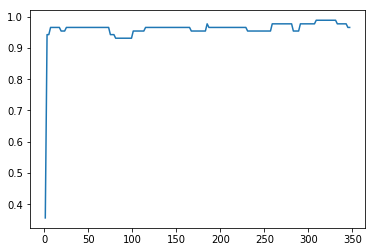

In [215]:
from pylab import *
import matplotlib.pyplot as plt
train_size = []
precision = []
for i in range(1, len(train_data), 2):
    dtree = decision_tree(train_data[0:i])
    train_size.append(i)
    precision.append(testClassification(dtree, test_data))
plt.plot(train_size,precision)
plt.show()

In [217]:
#convert the decision tree into dict form
def convert2dict(tree):
    if tree.children == []:
        return tree.label
    else:
        tree_dict = {}
        tree_dict[tree.featureSplit] = {}
        for child in tree.children:
            tree_dict[tree.featureSplit][child.featureValue] = convert2dict(child)
        return  tree_dict

# 2 the most prominant feature
it seems that the most prominant feature is the 3rd feature, column 4 in house-votes-1984.txt

# 3 the function to prune the decision tree

In [219]:
def decision_tree_pruning(data, test_data):
    size_threshold = len(data) * 0.02
    dtree = Tree()
    dtree.label=majority(data, [1] * len(data))
    precision = [0]
    precision[0] = testClassification(dtree, test_data)
    def buildTree_pruning(data, test_data, parent, remaining_feature, weight, precision):
        if [label for (point, label) in data].count(data[0][1]) == len(data):   # homogeneous
            parent.label = data[0][1]
            return parent
        # can't split anymore or data size is too small
        if len(remaining_feature) == 0 or len(data) <= size_threshold:     
            parent.label = majority(data, weight)
            return parent
        best_feature = max(remaining_feature, key=lambda feature: info_gain(data, feature, weight)) 
        maxGained = info_gain(data, best_feature, weight)
        if maxGained == 0:
            parent.label = majority(data, weight)
            return parent
    
        feature_values = [point[best_feature] for (point, label) in data]
        weight_intact_data = sum([point_weight for (point, label), point_weight in zip(data, weight) 
                                  if point[best_feature] != '?'])

        #calculate precision of test_data after pruning the decision tree
        parent.featureSplit = best_feature
        for aFeatureValue in set(feature_values)-set('?'):
            node = Tree(parent=parent)
            node.featureValue = aFeatureValue
            data_set = []
            weight_dataSet = []
            for (point, label), point_weight in zip(data, weight):  # process (point,label) with feature aFeatureValue first
                if point[best_feature] == aFeatureValue:
                    data_set.append((point, label))
                    weight_dataSet.append(point_weight)
            r = sum(weight_dataSet) / weight_intact_data  # the weight ratio of intact_dataSet to intact_data
            node.ratio = r
            for (point, label), point_weight in zip(data, weight):
                if point[best_feature] == '?':
                    data_set.append((point, label))
                    weight_dataSet.append(r * point_weight)
            node.label = majority(data_set, weight_dataSet)
            parent.children.append(node)
        precision_pruning = testClassification(dtree, test_data)
        if precision_pruning < precision[0]:   # do not split
            parent.children = []
            parent.featureSplit = None
            parent.label = majority(data, weight)
            return parent

        # split data
        precision[0] = precision_pruning
        parent.featureSplit = best_feature
        for aFeatureValue in set(feature_values)-set('?'):
            node = Tree(parent=parent)
            node.featureValue = aFeatureValue
            data_set = []
            weight_dataSet = []
            for (point, label), point_weight in zip(data, weight):  # process (point,label) with feature aFeatureValue first
                if point[best_feature] == aFeatureValue:
                    data_set.append((point, label))
                    weight_dataSet.append(point_weight)
            r = sum(weight_dataSet) / weight_intact_data  # the weight ratio of intact_dataSet to intact_data
            node.ratio = r
            for (point, label), point_weight in zip(data, weight):
                if point[best_feature] == '?':
                    data_set.append((point, label))
                    weight_dataSet.append(r * point_weight)
            node.label = majority(data_set, weight_dataSet)
            parent.children.append(node)
            buildTree_pruning(data_set,test_data, node, remaining_feature - set([best_feature]), weight_dataSet, precision)
        return parent
    buildTree_pruning(data, test_data, dtree, set(range(len(data[0][0]))), [1] * len(data), precision)
    return dtree

## plot classification accuracy after pruning the tree.
The graph is shown below. Obviously, the precision of tree with pruning is much stable.

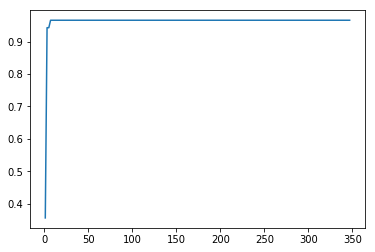

In [220]:
train_size = []
precision = []
for i in range(1, len(train_data), 2):
    dtree = decision_tree_pruning(train_data[0:i],test_data)
    train_size.append(i)
    precision.append(testClassification(dtree, test_data))
plt.plot(train_size,precision)
plt.show()

In [170]:
dtree = decision_tree(train_data)
dic = convert2dict(dtree)

In [221]:
# The following code plot the tree is from the blog-https://blog.csdn.net/sinat_29957455/article/details/76553987 with some modifications.
def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':
            numLeafs += getNumLeafs(secondDict[key])
        else:
            numLeafs += 1
    return numLeafs
def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:
            thisDepth = 1
        if thisDepth > maxDepth : maxDepth = thisDepth
    return maxDepth
decisionNode = dict(boxstyle = "sawtooth",fc="0.8")
leafNode = dict(boxstyle = "round4",fc="0.8")
arrow_args = dict(arrowstyle="<-")
def plotNode(nodeTxt,centerPt,parentPt,nodeType):
    createPlot.ax1.annotate(nodeTxt,xy=parentPt,\
    xycoords='axes fraction',xytext=centerPt,textcoords='axes fraction',\
    va="center",ha="center",bbox=nodeType,arrowprops=arrow_args)
 
def plotMidText(cntrPt,parentPt,txtString):
    xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]   
    yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]   
    createPlot.ax1.text(xMid,yMid,txtString)
def plotTree(myTree,parentPt,nodeTxt):
    numLeafs = getNumLeafs(myTree)
    depth = getTreeDepth(myTree)
    firstStr = list(myTree.keys())[0]
    cntrPt = (plotTree.xoff + (1.0 + float(numLeafs))/2.0/plotTree.totalW,\
              plotTree.yoff)
    plotMidText(cntrPt,parentPt,nodeTxt)
    plotNode(firstStr,cntrPt,parentPt,decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yoff = plotTree.yoff - 1.0/plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':
            plotTree(secondDict[key],cntrPt,str(key))
        else:
            plotTree.xoff = plotTree.xoff + 1.0 / plotTree.totalW
            plotNode(secondDict[key],(plotTree.xoff,plotTree.yoff),\
                     cntrPt,leafNode)
            plotMidText((plotTree.xoff,plotTree.yoff),cntrPt,str(key))
    plotTree.yoff = plotTree.yoff + 1.0 / plotTree.totalD
 
def createPlot(inTree):
    fig = plt.figure(1,facecolor='white')
    fig.clf()
    axprops = dict(xticks=[],yticks=[])
    createPlot.ax1 = plt.subplot(111,frameon=False,**axprops)
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xoff = -0.5/plotTree.totalW
    plotTree.yoff = 1.0
    plotTree(inTree,(0.5,1.0),'')
    plt.show()


# 4  Include a picture of the learned decision trees
    The graph of the tree with pruning was showed below

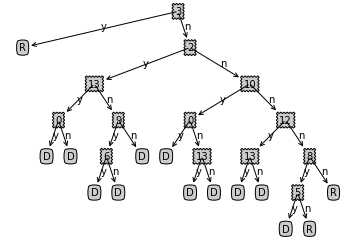

In [222]:
dtree = decision_tree_pruning(train_data, test_data)
dic = convert2dict(dtree)
createPlot(dic)

    The graph of the tree without pruning was showed below

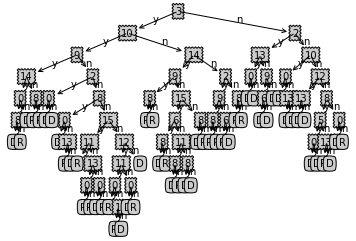

In [223]:
dtree = decision_tree(train_data)
dic = convert2dict(dtree)
createPlot(dic)